# Performing visual question answering (VQA) with ViLT

In this notebook, we are going to illustate visual question answering with the Vision-and-Language Transformer (ViLT). This model is very minimal: it only adds text embedding layers to an existing ViT model. It does not require any sophisticated CNN-based pipelines to feed the image to the model (unlike models like [PixelBERT](https://arxiv.org/abs/2004.00849) and [LXMERT](https://arxiv.org/abs/1908.07490)). This makes the model also much faster than previous works.

![ViLT architecture](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/vilt_architecture.jpg)

Figure taken from the original [paper](https://arxiv.org/abs/2102.03334).

HuggingFace docs: https://huggingface.co/docs/transformers/master/en/model_doc/vilt

## Set-up environment

First, we install HuggingFace Transformers.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.4 MB/s eta 0:00:00


## Prepare image + question

Here we take our familiar cats image (of the COCO dataset) and create a corresponding question.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


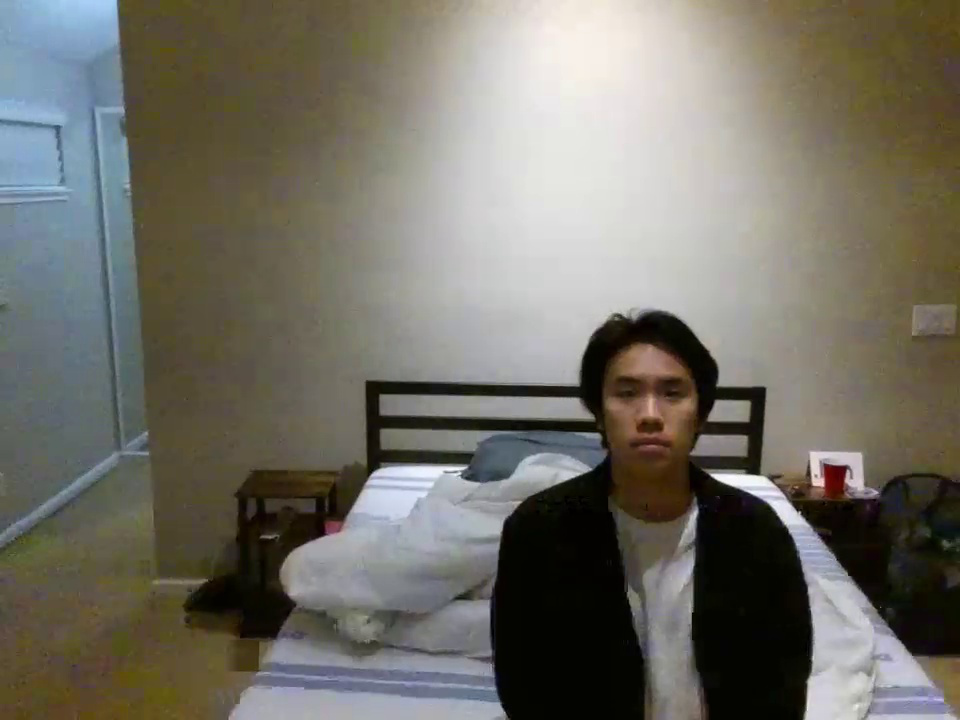

In [ ]:
import requests
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')

url = "https://drive.google.com/file/d/1EcPSZqGtpuDOUGXHcPzDaiFtRk19wWrV/view?usp=sharing"
image = Image.open('/content/drive/My Drive/Projects/DroneFormer/Images/Test_1/image_1676714750.5169861.jpg')
text = "What is the color of the jacket that the person in this image is wearing?"
image

In [ ]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

Let's prepare the image+text pair for the model. Here, we leverage `ViltProcessor`, which will use (behind the scenes):
* `BertTokenizerFast` to tokenize the text (and create input_ids, attention_mask, token_type_ids)
* `ViltFeatureExtractor` to resize + normalize the image (and create pixel_values and pixel_mask). 

Note that the `pixel_mask` is only relevant in case of batches, as it can be used to indicate which pixels are real/which are padding. Here we're only preparing a single example for the model, hence all values of pixel_mask will be 1.

In [ ]:
encoding = processor(image, text, return_tensors="pt")
for k,v in encoding.items():
  print(k, v.shape)

input_ids torch.Size([1, 18])
token_type_ids torch.Size([1, 18])
attention_mask torch.Size([1, 18])
pixel_values torch.Size([1, 3, 384, 512])
pixel_mask torch.Size([1, 384, 512])


## Define model

Here we load the ViLT model, fine-tuned on VQAv2, from the [hub](https://huggingface.co/dandelin/vilt-b32-finetuned-vqa).

In [ ]:
from transformers import ViltForQuestionAnswering 

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

## Forward pass

We can now forward both the `input_ids` and `pixel_values` through the model. The model outputs logits of shape (batch_size, num_labels), which in this case will be (1, 3129) - as the VQAv2 dataset has 3129 possible answers.

In [ ]:
import torch

# forward pass
outputs = model(**encoding)
logits = outputs.logits
idx = torch.sigmoid(logits).argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])

Predicted answer: black


In [ ]:
logits.shape

torch.Size([1, 3129])

In [ ]:
logits[0,:3]

tensor([-15.9495, -18.1472, -10.3041], grad_fn=<SliceBackward0>)